Goal: compress an image by clustering it's square components and replacing it's square components with its prototype

In [1]:
import matplotlib as mp
import matplotlib.pyplot as plot
import numpy as np
from sklearn import cluster
from fractions import gcd
from operator import mul

In [2]:
def pic_to_blocks(pic, side_length=10):
    '''takes picture matrix returns array of pic divided into blocks
        pic - numpy matrix of rgb or grayscale values
        side_length - length of side of cube must divide evenly into matrix length and width
    '''
    blocks = []
    for row in range(0, len(pic), side_length):
        for col in range(0, len(pic[row]), side_length):
            blocks.append(pic[row:row+side_length,col:col+side_length])
    return np.array(blocks)

def cluster_blocks(blocks, clusters=5):
    '''takes blocks from pic_to_blocks and clusters them'''
    points = np.array(map(lambda e: e.flatten(), blocks))
    model = cluster.KMeans(clusters)
    labels = model.fit_predict(points)
    block_shape = list(blocks)
    block_shape[0] = -1
    return model

def blockify(block_shape, flat_blocks):
    '''converts flattened blocks back to 2d array'''
    block_shape = list(block_shape)
    block_shape[0] = -1
    return flat_blocks.reshape(block_shape)

def encoding_to_block(codebook, encoding):
    '''creates array of block images by translating encoding with code book
        codebook - array where index is cluster encoding and value is image block
        encoding - array where each element is an encoding
    '''
    return map(lambda e: codebook[e], encoding)

def blocks_to_pic(blocks, pic_shape):
    '''takes an array of blocks of a pic and glues them back into a np array
        blocks - array of np arrays representing an image with grayscale or rgb values
        pic_shape - tuple with shape of the full picture. ex: (num_rows, num_columns)
    '''
    block_side = blocks[0].shape[0]
    blocks_in_row = pic_shape[1]/block_side
    blocks_in_col = pic_shape[0]/block_side
    connected_blocks = []
    for rowi in range(blocks_in_col):
        row = blocks[rowi*blocks_in_row:rowi*blocks_in_row+blocks_in_row]
        joined_row = np.concatenate(row, axis = 1)
        connected_blocks.append(joined_row)
    pic = np.concatenate(connected_blocks)
    return pic

def decompress_image(codebook, encoded_blocks, pic_shape):
    '''decompresses a kmeans compressed image'''
    decoded_blocks = encoding_to_block(codebook, encoded_blocks)
    pic = blocks_to_pic(decoded_blocks, pic_gray.shape)
    return pic

def rgb2gray(rgb):
    '''converts rgb np matrix image to grayscale np matrix image'''
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def compress_image(pic_matrix, block_side_size=2, clusters=50):
    '''takes a pic_matrix and returns the codebook and encoded blocks of the compressed image'''
    #break pic matrix into smaller squares
    blocks =  pic_to_blocks(pic_matrix, block_side_size)
    #cluster the blocks using each gray scale value
    model = cluster_blocks(blocks, clusters)
    #create array for translating compressed image blocks into real image blocks
    codebook = blockify(blocks.shape, model.cluster_centers_)
    #get cluster memberships for each block
    encoded_blocks = model.labels_
    return codebook, encoded_blocks

def eval_result(codebook, encoded_blocks, original):
    '''calculates and prints some metrics about the compression'''
    cb_size = codebook.size#np.ma.count(codebook)
    eb_size = encoded_blocks.size#np.ma.count(encoded_blocks)
    original_size = original.size
    encoding_bits = np.log2(codebook.shape[0]) * cb_size
    codebook_bits = cb_size*8
    print "codebook entries = %i" % cb_size
    print "encoded blocks entries = %i" % eb_size
    print "encoding bits = %i" % encoding_bits
    print "codebook bits = %i" % codebook_bits
    print "total compressed_bits = %i" % (encoding_bits + codebook_bits)
    print "full size in bits = %i" % (original_size * 8)
    print "compression ratio = %f" % (float(encoding_bits+codebook_bits)/(original_size*8))
    print "bits per pixel = %f" % (float(encoding_bits+codebook_bits)/original_size)

In [3]:
pic_rgb = np.array(plot.imread("tower-of-babel.jpg"))
pic_gray = rgb2gray(pic_rgb)

# 200 code vectors

First we run the compression with 4x4 block sizes and 200 clusters.

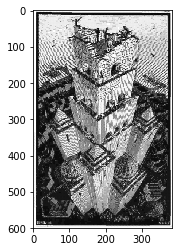

In [4]:
block_side = 4
clusters = 200
codebook, encoded_blocks = compress_image(pic_gray, block_side, clusters)
pic = decompress_image(codebook, encoded_blocks, pic_gray.shape)
plot.imshow(pic, cmap=plot.get_cmap("gray"))

In [5]:
eval_result(codebook, encoded_blocks, pic_gray)

codebook entries = 3200
encoded blocks entries = 14400
encoding bits = 24460
codebook bits = 25600
total compressed_bits = 50060
full size in bits = 1843200
compression ratio = 0.027159
bits per pixel = 0.217276


# 6 code vectors

Next we run the compression with 4x4 block sizes and 6 clusters.

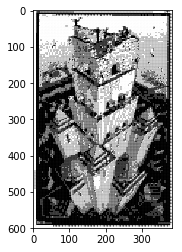

In [6]:
block_side = 4
clusters = 6
codebook, encoded_blocks = compress_image(pic_gray, block_side, clusters)
pic = decompress_image(codebook, encoded_blocks, pic_gray.shape)
plot.imshow(pic, cmap=plot.get_cmap("gray"))

In [7]:
eval_result(codebook, encoded_blocks, pic_gray)

codebook entries = 96
encoded blocks entries = 14400
encoding bits = 248
codebook bits = 768
total compressed_bits = 1016
full size in bits = 1843200
compression ratio = 0.000551
bits per pixel = 0.004410


## Results

We find that the image looks very close to the original picture.
This indicates that the picture has a low entropy, since it can be represented well with less information.

The 6 cluster result uses 50 times less space than the 200 cluster result, but has noticeably less quality.

Both the 6 and 200 cluster results led to drastic compression results.

Using 200 clusters took much longer than 6 clusters.

Less than 3% of the bits per pixel were needed by the compressed images when compared to a normal grayscale image.
However, the file uses only 81 KB on my hard drive due to the lossless compression algorithms associated with jpg files. Even when benchmarked against the 81KB file the 200 cluster result is almost 2 times smaller and the 6 cluster result is approximately 80 times smaller.

To further reduce the file size we can apply a huffman encoding or
similar algorithm to the codebook images. It is probable that the encoding
and the codebook are not uniformly distributed, so these data should be reducible losslessly.